In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io, scipy.optimize as op

# Programming Exercise 5: Regularized Linear Regression and Bias vs Variance

## 1. Regularized Linear Regression

In this part of the exercise, we will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. Suppose you have historical records on the
change in the water level and the amount of water flowing out of the dam (stored in `ex5data1.mat`). You can thus use a linear regression model to predict the extent of future outflows. As we will see later on, however, not all datasets are made equal (with this particular one being ill-suited for linear regression), prompting us to use polynomial regression and regularization.

### 1.1 Visualizing the Data

We want to see if this particular dataset is suited for linear regression. Thus, we plot the data containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$.

This dataset in particular is divided into three parts:
- A <b> training set </b> that the model will learn on: `X`, `y`
- A <b> cross validation set </b> for determining the regularization parameter: `Xval`, `yval`
- A <b> test set </b> for evaluating performance: `Xtest`, `ytest`

In our case, we want to plot only the training data, as we will be training the model on this dataset.

Because we have a `.mat` file, we use the scipy library to read the dataset. Furthermore, note that to account for the intercept term later on in the implementation of gradient descent, we append a column of ones to the left of the matrix $X$.

In [2]:
# Read .mat file
data = io.loadmat('ex5data1.mat')

# Separate into the different components
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']

# Add column of 1's to X's
X = np.c_[np.ones((len(y), 1)), X]
Xval = np.c_[np.ones((len(yval), 1)), Xval]
Xtest = np.c_[np.ones((len(ytest), 1)), Xtest]

Text(0, 0.5, 'Water flowing out of the dam')

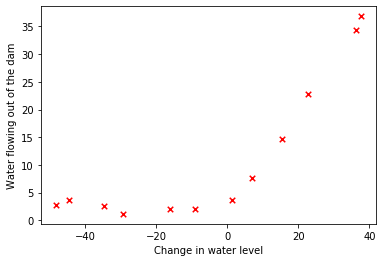

In [3]:
# Plot the data
plt.scatter(X[:, 1], y, marker = "x", c = "red", s = 30)
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")

We can see from the figure above that the data seems to exhibit a nonlinear trend. This necessitates the use of polynomial regression, which we will get to later on. However, with polynomial regression, there is the danger of overfitting, thus prompting the use of regularization.

### 1.2 Regularized Linear Regression Cost Function and Gradient

Recall that for linear regression, the cost function is given by

$\begin{equation}
J(\theta) = \frac{1}{2m}\sum_{i = 1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^{2}
\end{equation}$

where the hypothesis $h_{\theta}(x)$ is given by

$\begin{equation}
h_{\theta}(x) = \theta^{T}x = \theta_{0} + \theta_{1}x_{1}
\end{equation}$

In regularization, we introduce the regularization parameter $\lambda$, so that the cost function becomes

$\begin{equation}
J(\theta) = \frac{1}{2m}\sum_{i = 1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^{2} + \frac{\lambda}{2m}\sum_{j = 1}^{n}(\theta_j^{2})
\end{equation}$

The parameter $\lambda$ is our regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overal cost $J$. As the magnitudes of the model parameters $\theta_{j}$ increase, the penalty increases as well.

Note that $\theta_{0}$ - the constant term - should not be included in the regularization.

Correspondingly, the partial derivative of regularized linear regression’s cost for $\theta_{j}$ is defined for $j = 0$ as:

$\begin{equation}
    \frac{\partial J(\theta)}{\partial\theta_{0}} = \frac{1}{m}\sum_{i = 1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)}
\end{equation}$

and for $j \geq 1$ as

$\begin{equation}
    \frac{\partial J(\theta)}{\partial\theta_{0}} = \frac{1}{m}\sum_{i = 1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)} + \frac{\lambda}{m}\theta_{j}
\end{equation}$

These are all implemented in `linearRegCostFunction` below.

In [4]:
# linearRegCostFunction computes cost and gradient for regularized linear regression with multiple variables
def linearRegCostFunction(X, y, theta, lmbda):
    # Initialize values
    m = len(y)
    J = 0
    
    # Compute cost
    prediction = X @ theta
    error = prediction - y
    J = 1 / (2 * m) * np.sum(error ** 2) + lmbda / (2 * m) * np.sum(theta[1:] ** 2)
    
    # Compute gradient
    grad = (1 / m) * np.sum(error.T * X.T, axis = 1)[:, np.newaxis] + lmbda / m * np.r_[np.zeros((1, 1)), theta[1:]]
    
    return J, grad

In [5]:
# Tests
theta = np.array([1, 1]).reshape(-1, 1)
J, grad = linearRegCostFunction(X, y, theta, 1)
print("With theta = [1, 1]\nCost computed = ", J)
print("Expected cost value (approx) 303.993192\n")

print("With theta = [1, 1]\nGradient computed = \n", grad[0, 0], "\n", grad[1, 0], "\n")
print("Expected cost value (approx) \n -15.303016 \n 598.250744\n")

With theta = [1, 1]
Cost computed =  303.9931922202643
Expected cost value (approx) 303.993192

With theta = [1, 1]
Gradient computed = 
 -15.303015674201186 
 598.2507441727035 

Expected cost value (approx) 
 -15.303016 
 598.250744



### 1.3 Fitting Linear Regression

We will now use the `trainLinearReg` function to compute the optimal values of $\theta$ using the conjugate gradient method. This function uses `minimize` from the scipy.optimize library to optimize the cost function. 

Recall that the `minimize` function takes in the following arguments:
- The dataset (X, y) (argument `args`)
- The optimization method (argument `method`)
- The initial values of the parameters we are trying to optimize (argument `x0`)
- A function that, when given the training set and a particular $\theta$, computes the logistic regression cost (argument `fun`)
- A function that, when given the training set and a particular $\theta$, computes the gradient with respect to $\theta$ (argument `jac`)

Again, we need to separate `linearRegCostFunction` so that we have one function calculating the cost and another calculating the gradient. Furthermore, since `x0` must be a 1D array, we modify the functions accordingly to account for this, so that `theta` and `grad` are all 1-dimensional.

We implement the optimization below and store the optimum cost and $\theta$.

In [6]:
# Separate cost and gradient computations
def linearRegCostFunction(theta, X, y, lmbda):
    # Initialize values
    m = len(y)
    J = 0
    
    # Compute cost
    prediction = X @ theta[:, np.newaxis]
    error = prediction - y
    J = 1 / (2 * m) * np.sum(error ** 2) + lmbda / (2 * m) * np.sum(theta[1:] ** 2)
    
    return J

def linearRegGradFunction(theta, X, y, lmbda):
    # Initialize values
    m = len(y)
    
    # Compute gradient
    prediction = X @ theta[:, np.newaxis]
    error = prediction - y
    grad = (1 / m) * np.sum(error.T * X.T, axis = 1) + lmbda / m * np.r_[0, theta[1:]]
    
    return grad

In [7]:
# trainLinearReg trains linear regression given a dataset (X, y) and a regularization parameter lambda
def trainLinearReg(X, y, lmbda):
    # Initialize theta
    initial_theta = np.zeros(X.shape[1]) 

    # Compute for optimal theta using conjugate gradient
    result = op.minimize(fun = linearRegCostFunction, jac = linearRegGradFunction, x0 = initial_theta, args = (X, y, lmbda), method = 'CG')
    theta = result.x
    
    return theta

Text(0, 0.5, 'Water flowing out of the dam')

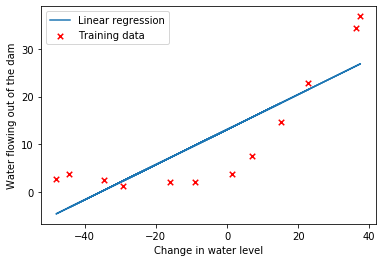

In [8]:
# Train regularized linear regression model on data
lmbda = 0      # Corresponding to no regularization
theta = trainLinearReg(X, y, lmbda)
 
# Plot the data
plt.scatter(X[:, 1], y, marker = "x", c = "red", s = 30, label = "Training data")

# Plot the best-fit line
plt.plot(X[:, 1], X @ theta[:, np.newaxis], label = "Linear regression")

# Annotate graph
plt.legend()
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")

## 2. Bias-Variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

### 2.1 Learning Curves

We will now generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. To obtain different training set sizes, we use different subsets of the original training set X and use `trainLinearReg` to find the optimal $\theta$. After learning the $\theta$ parameters, we compute the error on the training and cross-validation sets. Recall that the training error for a dataset is defined as:

$\begin{equation}
J_{train}(\theta) = \frac{1}{2m}\sum_{i = 1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^{2}
\end{equation}$

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross-validation error. When you are computing the training set error, make sure you compute it on the training subset (instead of the entire training set). However, for the cross-validation error, you should compute it over the entire cross validation set.

In [9]:
# learningCurve generates the train and cross validation set errors needed to plot a learning curve
def learningCurve(X, y, Xval, yval, lmbda):
    
    # Initialize error_train and error_val
    m = X.shape[0]
    error_train = np.zeros(m - 1)
    error_val = np.zeros(m - 1)
     
    # Calculate error
    for i in range(2, m + 1):
        Xtr= X[:i, :]
        ytr = y[:i]
        
        # Find optimal theta
        theta = trainLinearReg(Xtr, ytr, lmbda)
        
        # Get training and cross-validation error
        error_train[i - 2] = linearRegCostFunction(theta, Xtr, ytr, lmbda = 0)
        error_val[i - 2] = linearRegCostFunction(theta, Xval, yval, lmbda = 0)
        
    return error_train, error_val

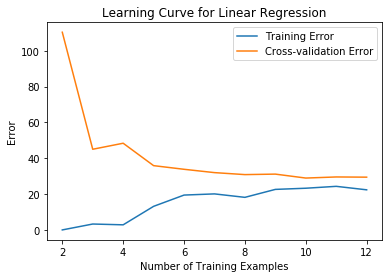

In [10]:
# Compute error_train and error_val
error_train, error_val = learningCurve(X, y, Xval, yval, 0)

# Plot training and cross-validation errors
plt.plot(np.arange(2, 13, 1), error_train, label = "Training Error")
plt.plot(np.arange(2, 13, 1), error_val, label = "Cross-validation Error")
plt.xlabel("Number of Training Examples")
plt.ylabel("Error")
plt.title("Learning Curve for Linear Regression")
plt.legend()

We can observe that both the train error and cross-validation error are high when the number of training examples is increased. This reflects a high bias problem in the model – the linear regression model is too simple and is unable to fit our dataset well. Thus, we need to employ a different model specification.

## 3. Polynomial Regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). Thus, we address the problem by adding more features.

For polynomial regression, our hypothesis has the form:

$h_{\theta}(x) = \sum_{i = 1}^{p}(\theta_{p}x^{p})$

By defining $x = (waterLevel)$, $x^{2} = (waterLevel)^{2}$, $\cdots$, $x^{p} = (waterLevel)^{p}$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel). In the function below (`polyFeatures`), we implement this procedure. Specifically, when we pass a training set X of size $m \times 1$ into `polyFeatures`, it should return an $m \times p$ matrix, where column 0 holds a column of 1's, column 1 holds the original values of $X$, column 2 holds the values of $X^{2}$, column 3 holds the values of $X^{3}$, and so on.

In [11]:
# polyFeatures maps X (2D vector) into the p-th power
def polyFeatures(X, p):
    # Initialize X_poly
    X_poly = np.zeros((X.shape[0], p + 1))
    X_poly[:, :2] = X
    
    # Build X_poly
    for i in range(2, p + 1):
        X_poly[:, i] = X[:, 1] ** i
        
    return X_poly

### 3.1 Learning Polynomial Regression

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression.

Let us assume that we want to fit a polynomial of degree 8 onto the data. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled. This necessitates the use of feature normalization, which we have already implemented below.

In [12]:
# featureNormalize returns a normalized version of X where the mean value of each feature is 0 and the standard 
# deviation is 1. This is often a good preprocessing step to do when working with learning algorithms.
def featureNormalize(X):
    # Initialize values
    X = X[:, 1:]
    
    # Get mean and normalize
    mu = np.mean(X, 0)[np.newaxis, :]
    X = X - mu
    
    # Get standard deviation and normalize
    sigma = np.std(X, 0)[np.newaxis, :]
    X = X / sigma

    # Append column of 1's
    X_norm = np.c_[np.ones((X.shape[0], 1)), X]

    return X_norm, mu, sigma

After calling `featureNormalize`, we are now ready to learn the parameters $\theta$.  

Text(0.5, 1.0, 'Polynomial regression, $\\lambda$ = 0')

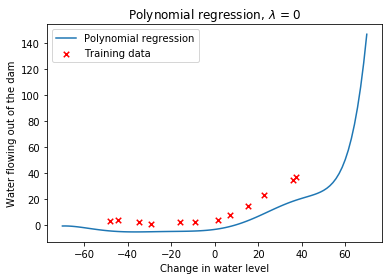

In [13]:
# Create normalized polynomial feature matrix
X_poly = polyFeatures(X, 8)
X_norm, mu, sigma = featureNormalize(X_poly)

# Train model
theta = trainLinearReg(X_norm, y, lmbda = 0)

# Plot the data
plt.scatter(X[:, 1], y, marker = "x", c = "red", s = 30, label = "Training data")

# Plot the best-fit polynomial
plot_range = np.linspace(-70, 70, 100)
X_plot = np.c_[np.ones((len(plot_range), 1)), plot_range.reshape((len(plot_range), 1))]
X_plot, mu, sigma = featureNormalize(polyFeatures(X_plot, 8))
plt.plot(plot_range, X_plot @ theta, label = "Polynomial regression")

# Annotate graph
plt.legend()
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")
plt.title("Polynomial regression, $\lambda$ = 0")

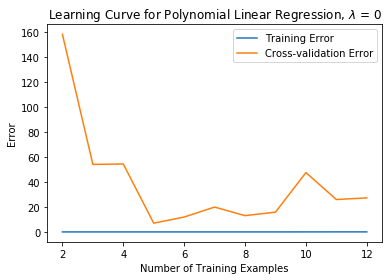

In [14]:
# Compute error_train and error_val
Xval_norm, mu, sigma = featureNormalize(polyFeatures(Xval, 8))
error_train, error_val = learningCurve(X_norm, y, Xval_norm, yval, 0)

# Plot training and cross-validation errors
plt.plot(np.arange(2, 13, 1), error_train, label = "Training Error")
plt.plot(np.arange(2, 13, 1), error_val, label = "Cross-validation Error")
plt.xlabel("Number of Training Examples")
plt.ylabel("Error")
plt.title("Learning Curve for Polynomial Linear Regression, $\lambda$ = 0")
plt.legend()

The first figure above shows that the polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized ($\lambda$ = 0) model, you can see that the learning curve (second figure above) shows the same effect where the low training error is low, but the cross-validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem. One way to combat the overfitting (high-variance) problem is to add regularization to the model.

### 3.2 Adjusting the Regularization Parameter

We try out different values of $\lambda$ starting with $\lambda$ = 1.

Text(0.5, 1.0, 'Polynomial regression, $\\lambda$ = 1')

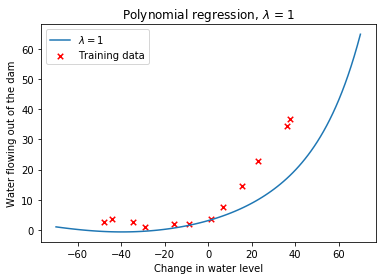

In [15]:
# Train model
theta = trainLinearReg(X_norm, y, lmbda = 1)

# Plot the data
plt.scatter(X[:, 1], y, marker = "x", c = "red", s = 30, label = "Training data")

# Plot the best-fit polynomial
plot_range = np.linspace(-70, 70, 100)
X_plot = np.c_[np.ones((len(plot_range), 1)), plot_range.reshape((len(plot_range), 1))]
X_plot, mu, sigma = featureNormalize(polyFeatures(X_plot, 8))
plt.plot(plot_range, X_plot @ theta, label = "$\lambda = 1$")

# Annotate graph
plt.legend()
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")
plt.title("Polynomial regression, $\lambda$ = 1")

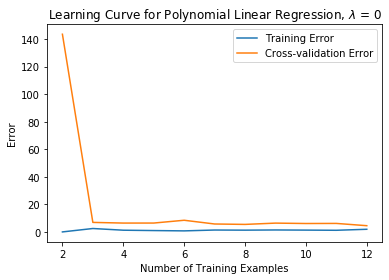

In [16]:
# Compute error_train and error_val
Xval_norm, mu, sigma = featureNormalize(polyFeatures(Xval, 8))
error_train, error_val = learningCurve(X_norm, y, Xval_norm, yval, 1)

# Plot training and cross-validation errors
plt.plot(np.arange(2, 13, 1), error_train, label = "Training Error")
plt.plot(np.arange(2, 13, 1), error_val, label = "Cross-validation Error")
plt.xlabel("Number of Training Examples")
plt.ylabel("Error")
plt.title("Learning Curve for Polynomial Linear Regression, $\lambda$ = 0")
plt.legend()

For $\lambda$ = 1, we see a polynomial fit that follows the data trend well and a learning curve showing that both the cross-validation and training error converge to a relatively low value. This shows the $\lambda$ = 1 regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

Text(0.5, 1.0, 'Polynomial regression, $\\lambda$ = 100')

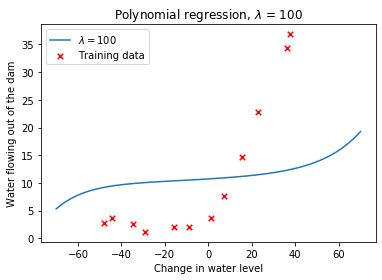

In [17]:
# Train model
theta = trainLinearReg(X_norm, y, lmbda = 100)

# Plot the data
plt.scatter(X[:, 1], y, marker = "x", c = "red", s = 30, label = "Training data")

# Plot the best-fit polynomial
plot_range = np.linspace(-70, 70, 100)
X_plot = np.c_[np.ones((len(plot_range), 1)), plot_range.reshape((len(plot_range), 1))]
X_plot, mu, sigma = featureNormalize(polyFeatures(X_plot, 8))
plt.plot(plot_range, X_plot @ theta, label = "$\lambda = 100$")

# Annotate graph
plt.legend()
plt.xlabel("Change in water level")
plt.ylabel("Water flowing out of the dam")
plt.title("Polynomial regression, $\lambda$ = 100")

Meanwhile, for $\lambda$ = 100, you should see a polynomial fit that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

### 3.3 Selecting $\lambda$ using a Cross-Validation Set

The value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross-validation set. A model without regularization ($\lambda$ = 0) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($\lambda$ = 100) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda$ = 1) can provide a good fit to the data.

We will now implement an automated method to select the $\lambda$ parameter. Concretely, we will use a cross validation set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross-validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.

In [18]:
#validationCurve generates the train and validation errors needed to plot a validation curve that we can use to
# select lambda
def validationCurve(X, y, Xval, yval):
    # Initialize variables
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 2, 3, 4, 5, 10]
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))
    
    for i in range(len(lambda_vec)):
        # Find optimal theta
        X_norm, mu, sigma = featureNormalize(polyFeatures(X, 8))
        Xval_norm, mu, sigma = featureNormalize(polyFeatures(Xval, 8))
        theta = trainLinearReg(X_norm, y, lambda_vec[i])
        
        # Get training and cross-validation error
        error_train[i] = linearRegCostFunction(theta, X_norm, y, lmbda = 0)
        error_val[i] = linearRegCostFunction(theta, Xval_norm, yval, lmbda = 0)
        
    return error_train, error_val

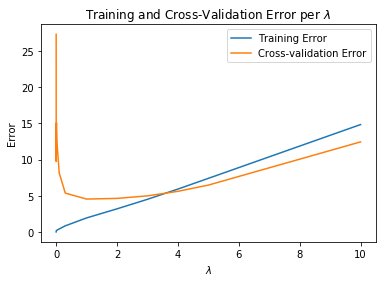

In [19]:
# Compute error_train and error_val
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 2, 3, 4, 5, 10]
error_train, error_val = validationCurve(X, y, Xval, yval)

# Plot training and cross-validation errors
plt.plot(lambda_vec, error_train, label = "Training Error")
plt.plot(lambda_vec, error_val, label = "Cross-validation Error")
plt.xlabel("$\lambda$")
plt.ylabel("Error")
plt.title("Training and Cross-Validation Error per $\lambda$")
plt.legend()

In this figure, we can see that the best value of λ is around 3 (where the training error and cross-validation error converge). Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.

In [20]:
# Compute for test error
X_norm, mu, sigma = featureNormalize(polyFeatures(X, 8))
theta = trainLinearReg(X_norm, y, 3)

Xtest_norm, mu, sigma = featureNormalize(polyFeatures(Xtest, 8))
error_test = linearRegCostFunction(theta, Xtest_norm, ytest, 0)
print(error_test)

11.770318121221754


In our cross validation, we obtained a test error of 11.7703 for $\lambda$ = 3